## EV Adoption Forecasting
As electric vehicle (EV) adoption surges, urban planners need to anticipate infrastructure needs—especially charging stations. Inadequate planning can lead to bottlenecks, impacting user satisfaction and hindering sustainability goals.

**Problem Statement:** Using the electric vehicle dataset (which includes information on EV populations, vehicle types, and possibly historical charging usage), create a model to forecast future EV adoption. For example, predict the number of electric vehicles in upcoming years based on the trends in the data.

**Goal:** Build a regression model that forecasts future EV adoption demand based on historical trends in EV growth, types of vehicles, and regional data.

**Dataset:** This dataset shows the number of vehicles that were registered by Washington State Department of Licensing (DOL) each month. The data is separated by county for passenger vehicles and trucks.

- Date: Counts of registered vehicles are taken on this day (the end of this month). - 2017-01-31
2024-02-29
- County: This is the geographic region of a state that a vehicle's owner is listed to reside within. Vehicles registered in Washington
- State: This is the geographic region of the country associated with the record. These addresses may be located in other
- Vehicle Primary Use: This describes the primary intended use of the vehicle.(Passenger-83%, Truck-17%)
- Battery Electric Vehicles (BEVs): The count of vehicles that are known to be propelled solely by an energy derived from an onboard electric battery.
- Plug-In Hybrid Electric Vehicles (PHEVs): The count of vehicles that are known to be propelled from energy partially sourced from an onboard electric battery
- Electric Vehicle (EV) Total: The sum of Battery Electric Vehicles (BEVs) and Plug-in Hybrid Electric Vehicles (PHEVs).
- Non-Electric Vehicle Total: The count of vehicles that are not electric vehicles.
- Total Vehicles: All powered vehicles registered in the county. This includes electric vehicles.
- Percent Electric Vehicles: Comparison of electric vehicles versus their non-electric counterparts.

**Dataset Link:** https://www.kaggle.com/datasets/sahirmaharajj/electric-vehicle-population-size-2024/data

### Import Required Libraries

### pip install pandas numpy matplotlib seaborn scikit-learn # global env

In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Load Dataset

In [2]:
# Load data
df = pd.read_csv("Electric_Vehicle_Population_By_County.csv")
# Add this after loading data (Cell 3)
df['Total Vehicles'] = df['Total Vehicles'].str.replace(',', '').astype(int)
df['Non-Electric Vehicle Total'] = df['Non-Electric Vehicle Total'].str.replace(',', '').astype(int)
df['Battery Electric Vehicles (BEVs)'] = pd.to_numeric(df['Battery Electric Vehicles (BEVs)'], errors='coerce')
df['Plug-In Hybrid Electric Vehicles (PHEVs)'] = pd.to_numeric(df['Plug-In Hybrid Electric Vehicles (PHEVs)'], errors='coerce')

### Explore and Understand the Data

In [3]:
df.head() # top 5 rows

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,September 30 2022,Riverside,CA,Passenger,7.0,0.0,7,460,467,1.50
1,December 31 2022,Prince William,VA,Passenger,1.0,2.0,3,188,191,1.57
2,January 31 2020,Dakota,MN,Passenger,0.0,1.0,1,32,33,3.03
3,June 30 2022,Ferry,WA,Truck,0.0,0.0,0,3575,3575,0.00
4,July 31 2021,Douglas,CO,Passenger,0.0,1.0,1,83,84,1.19


Total 20819 data points and 10 features.

In [4]:
# no of rows and cols
df.shape

(20819, 10)

In [5]:
# Data Types, class and memory alloc
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20819 entries, 0 to 20818
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      20819 non-null  object 
 1   County                                    20733 non-null  object 
 2   State                                     20733 non-null  object 
 3   Vehicle Primary Use                       20819 non-null  object 
 4   Battery Electric Vehicles (BEVs)          20266 non-null  float64
 5   Plug-In Hybrid Electric Vehicles (PHEVs)  20468 non-null  float64
 6   Electric Vehicle (EV) Total               20819 non-null  object 
 7   Non-Electric Vehicle Total                20819 non-null  int64  
 8   Total Vehicles                            20819 non-null  int64  
 9   Percent Electric Vehicles                 20819 non-null  float64
dtypes: float64(3), int64(2), object(5)

As we could see, only Percent Eletric Vehicles is numeric.

In [6]:
df.isnull().sum()

Date                                          0
County                                       86
State                                        86
Vehicle Primary Use                           0
Battery Electric Vehicles (BEVs)            553
Plug-In Hybrid Electric Vehicles (PHEVs)    351
Electric Vehicle (EV) Total                   0
Non-Electric Vehicle Total                    0
Total Vehicles                                0
Percent Electric Vehicles                     0
dtype: int64

Missing values in County and State.

**Check if any column contain outliers.**

In [7]:
# Compute Q1 and Q3
Q1 = df['Percent Electric Vehicles'].quantile(0.25)
Q3 = df['Percent Electric Vehicles'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print('lower_bound:', lower_bound)
print('upper_bound:', upper_bound)

# Identify outliers
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])

lower_bound: -3.5174999999999996
upper_bound: 6.9025
Number of outliers in 'Percent Electric Vehicles': 2476


### Data Preprocessing

Basic Data Cleaning

In [8]:
# Converts the "Date" column to actual datetime objects
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Removes rows where "Date" conversion failed
df = df[df['Date'].notnull()]

# Removes rows where the target (EV Total) is missing
df = df[df['Electric Vehicle (EV) Total'].notnull()]

# Fill missing values
df['County'] = df['County'].fillna('Unknown')
df['State'] = df['State'].fillna('Unknown')

# Confirm remaining nulls
print("Missing after fill:")
print(df[['County', 'State']].isnull().sum())

df.head()

Missing after fill:
County    0
State     0
dtype: int64


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,2022-09-30,Riverside,CA,Passenger,7.0,0.0,7,460,467,1.50
1,2022-12-31,Prince William,VA,Passenger,1.0,2.0,3,188,191,1.57
2,2020-01-31,Dakota,MN,Passenger,0.0,1.0,1,32,33,3.03
3,2022-06-30,Ferry,WA,Truck,0.0,0.0,0,3575,3575,0.00
4,2021-07-31,Douglas,CO,Passenger,0.0,1.0,1,83,84,1.19


Remove Outliers: Cap the values to the IQR bounds

In [9]:
# Cap the outliers - it keeps all the data while reducing the skew from extreme values.

df['Percent Electric Vehicles'] = np.where(df['Percent Electric Vehicles'] > upper_bound, upper_bound,
                                 np.where(df['Percent Electric Vehicles'] < lower_bound, lower_bound, df['Percent Electric Vehicles']))

# Identify outliers
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])

Number of outliers in 'Percent Electric Vehicles': 0


In [10]:
# Extract year and month from Date for trend analysis
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month


Enhanced Data Summary:
       Percent Electric Vehicles
count               20819.000000
mean                    2.122378
std                     2.277542
min                     0.000000
25%                     0.390000
50%                     1.220000
75%                     2.995000
max                     6.902500


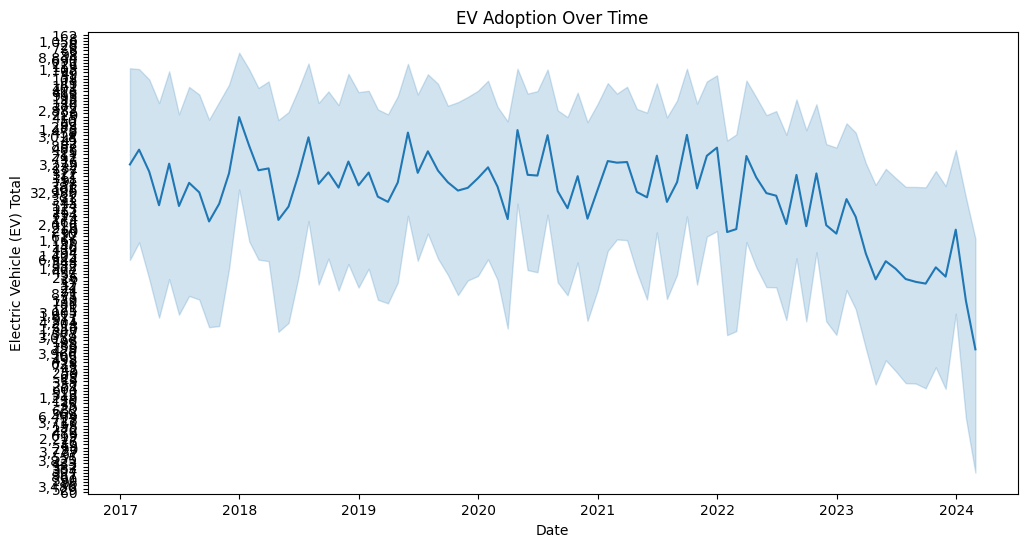

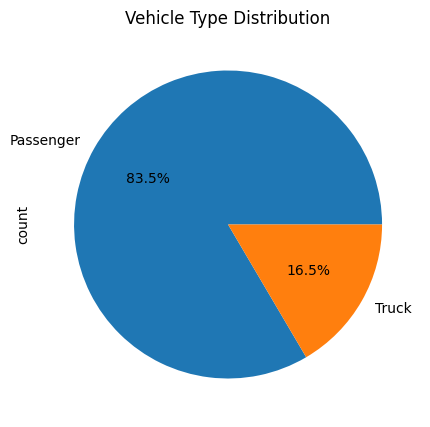

In [11]:
# Add new cell at the end
plt.figure(figsize=(12,6))
# Plot EV adoption trend
sns.lineplot(data=df, x='Date', y='Electric Vehicle (EV) Total')
plt.title('EV Adoption Over Time')
plt.savefig('ev_trend.png')  # Save for your presentation

# Plot vehicle type distribution
plt.figure(figsize=(8,5))
df['Vehicle Primary Use'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Vehicle Type Distribution')
plt.savefig('vehicle_types.png')
# Add after outlier treatment (Cell 10)
# Convert date to proper datetime format
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Add summary statistics
print("\nEnhanced Data Summary:")
print(df[['Electric Vehicle (EV) Total', 'Percent Electric Vehicles']].describe())

In [12]:
print("\nEnhanced Data Summary:")
print(df[['Electric Vehicle (EV) Total', 'Percent Electric Vehicles']].describe())


Enhanced Data Summary:
       Percent Electric Vehicles
count               20819.000000
mean                    2.122378
std                     2.277542
min                     0.000000
25%                     0.390000
50%                     1.220000
75%                     2.995000
max                     6.902500


<Axes: xlabel='Date', ylabel='Electric Vehicle (EV) Total'>

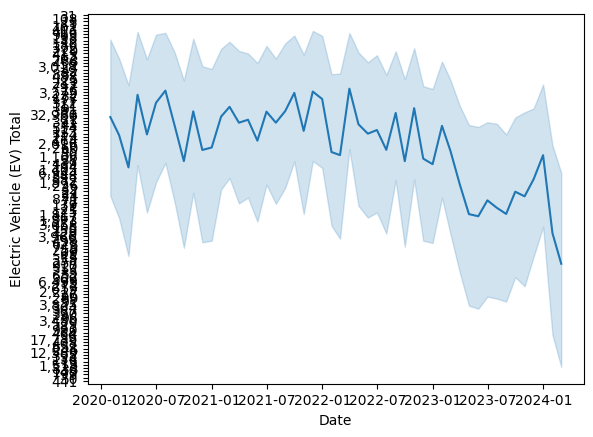

In [13]:
sns.lineplot(data=df[df['Year'] >= 2020], x='Date', y='Electric Vehicle (EV) Total')